# mittlere Zwischenankungtszeit

In [2]:
import json
import pandas as pd
import numpy as np
import random

In [3]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_solver__with_arrivals as ssv

In [4]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [5]:
def get_all_machine_ids(job_shop_matrix):
    machines = set()
    for job in job_shop_matrix:
        for operation in job:
            machines.add(operation[0])
    return machines

## I) Mittlere Zwischenankunftszeit t_a

### 1. Vektor der Bearbeitungszeiten auf der Engpassmaschine

#### a) Bestimmung der Engpassmaschine (7.12)

$$
m_{\text{max}} = \arg\max_{m \in M} T_m
$$

In [10]:
def get_engpassmaschine(jobs: dict, debug=False):
    machine_usage = {}
    for job_ops in jobs.values():
        for machine, duration in job_ops:
            machine_usage[machine] = machine_usage.get(machine, 0) + duration
    if debug:
        print("\nEndstand Maschinenbelastung:", machine_usage)
    return max(machine_usage, key=machine_usage.get)

get_engpassmaschine(instance, debug = True)


Endstand Maschinenbelastung: {0: 493, 1: 548, 2: 556, 3: 631, 4: 534, 5: 416, 6: 491, 7: 499, 8: 531, 9: 410}


3

#### b) Vektor der Bearbeitungszeiten auf der Engpassmaschine erstellen

In [12]:
def get_vec_t_b_mmax(jobs: dict) -> list:
    # Engpassmaschine bestimmen
    engpassmaschine = get_engpassmaschine(jobs)

    # Vektor der Bearbeitungszeiten auf der Engpassmaschine
    vec_t_b_mmax = []
    for job in jobs.values():
        duration = next((d for m, d in job if m == engpassmaschine), 0)
        vec_t_b_mmax.append(duration)

    return vec_t_b_mmax


In [13]:
vec_t_b_mmax = get_vec_t_b_mmax(instance)
vec_t_b_mmax

[36, 69, 39, 98, 26, 95, 61, 79, 76, 52]

### 2. Job-Wahrscheinlichkeiten

In [15]:
# Gleichverteilt 
n_jobs = len(instance)
p = [1 / n_jobs] * n_jobs
p

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

### 3. Berechne die mittlere Zwischenankunftszeit t_a nach Formel (7.16)

$$
t_a = \frac{\vec{p}^T \cdot \vec{t}_{b, m_{\text{max}}}}{u_{b, m_{\text{max}}}}
$$

- $t_a$: mittlere Zwischenankunftszeit  
- $\vec{p}$: Vektor der Wahrscheinlichkeiten der Arbeitspläne (bzw. Jobs)  
- $\vec{t}_{b, m_{\text{max}}}$: Vektor der Bearbeitungszeiten auf der Engpassmaschine  
- $u_{b, m_{\text{max}}}$: gewünschte Auslastung der Engpassmaschine


In [18]:
def calculate_mean_interarrival_time(jobs: dict, u_b_mmax: float = 0.9) ->float:
    """
    Berechnet die mittlere Interarrival-Zeit t_a, sodass die Engpassmaschine
    mit Auslastung u_b_mmax (< 1.0) betrieben wird.
    """
    n_jobs = len(jobs)
    p = [1 / n_jobs] * n_jobs
    vec_t_b_mmax = get_vec_t_b_mmax(jobs)
    t_a = sum(p[i] * vec_t_b_mmax[i] for i in range(n_jobs)) / u_b_mmax
    return np.round(t_a, 2)


In [19]:
t_a =  calculate_mean_interarrival_time(instance, u_b_mmax = 0.9)
t_a

70.11

## II) Ankunftszeiten

#### Generierung eine zufällige Job-Reihenfolge

In [22]:
job_names = list(instance.keys())
n_jobs = len(job_names)

# Permutiere Jobnamen
np.random.seed(12)
shuffled_jobs = list(np.random.permutation(job_names))
shuffled_jobs

['job 5',
 'job 8',
 'job 7',
 'job 0',
 'job 4',
 'job 9',
 'job 3',
 'job 2',
 'job 1',
 'job 6']

#### Generierung exponentiell verteilte Zwischenankunftszeiten mit Mittelwert t_a

In [24]:
np.random.seed(123)
interarrival_times = np.random.exponential(scale=t_a, size=n_jobs)

# Berechne absolute Ankunftszeiten
arrival_times = np.cumsum(interarrival_times)
arrival_times = np.round(arrival_times, 2)

# Kombiniere Reihenfolge und Zeitpunkte
job_arrivals = list(zip(shuffled_jobs, arrival_times))

# Ausgabe als DataFrame
df_arrivals = pd.DataFrame(job_arrivals, columns=["Job", "Arrival"])
df_arrivals = df_arrivals.sort_values(by="Arrival").reset_index(drop=True)
df_arrivals

,Job,Arrival
0,job 5,83.59
1,job 8,107.22
2,job 7,125.26
3,job 0,181.45
4,job 4,270.56
5,job 9,309.13
6,job 3,586.13
7,job 2,667.09
8,job 1,713.06
9,job 6,747.96


## III) Scheduling

### a) First Come First Serve

In [27]:
df_fcfs = ssv.schedule_fcfs_with_arrivals(instance, df_arrivals)
df_fcfs

,Job,Arrival,Machine,Start,Processing Time,End
0,job 5,83.59,M2,83.59,84,167.59
2,job 5,83.59,M1,167.59,2,169.59
4,job 5,83.59,M5,169.59,52,221.59
8,job 5,83.59,M3,221.59,95,316.59
12,job 5,83.59,M8,316.59,48,364.59
...,...,...,...,...,...,...
87,job 6,747.96,M5,1183.22,21,1204.22
89,job 6,747.96,M9,1204.22,32,1236.22
90,job 6,747.96,M8,1236.22,89,1325.22
96,job 6,747.96,M7,1351.22,30,1381.22


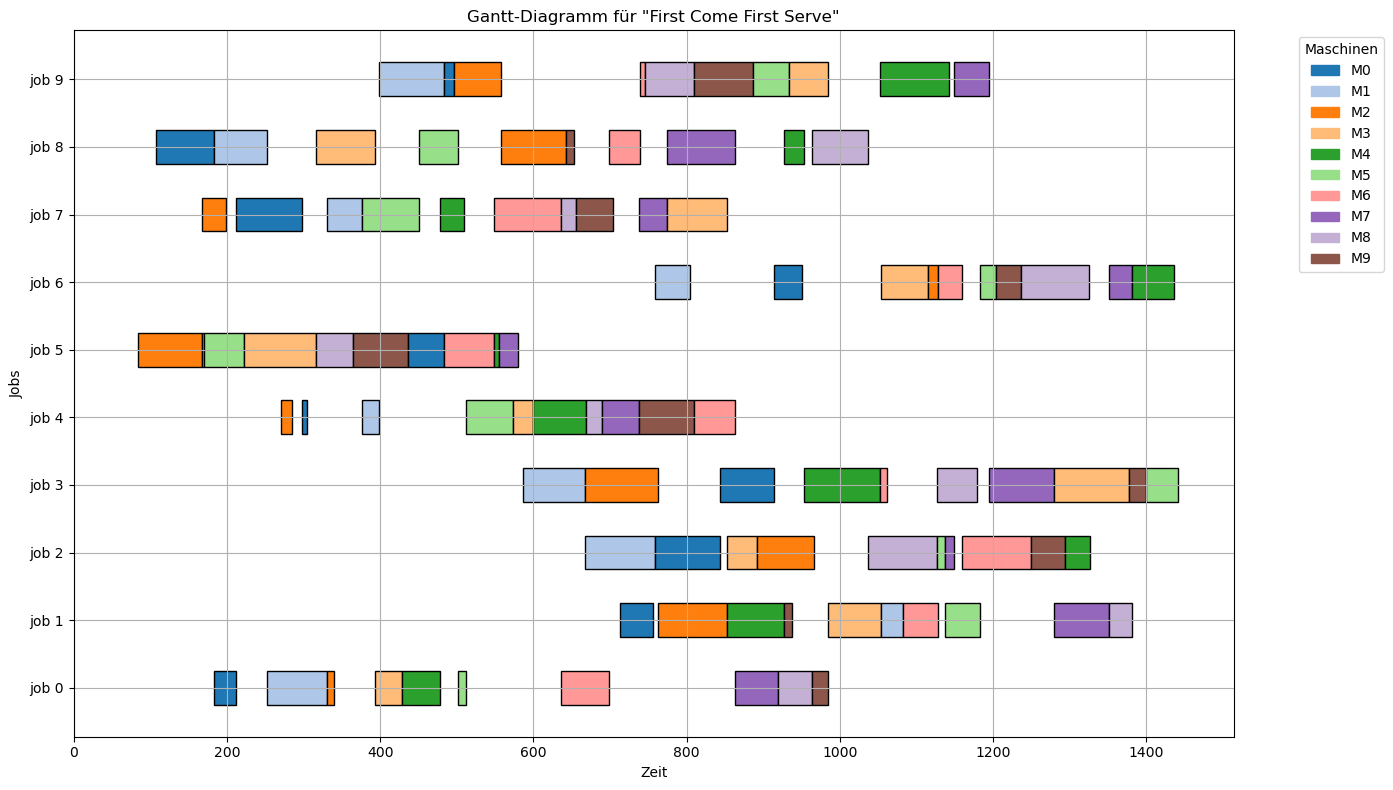

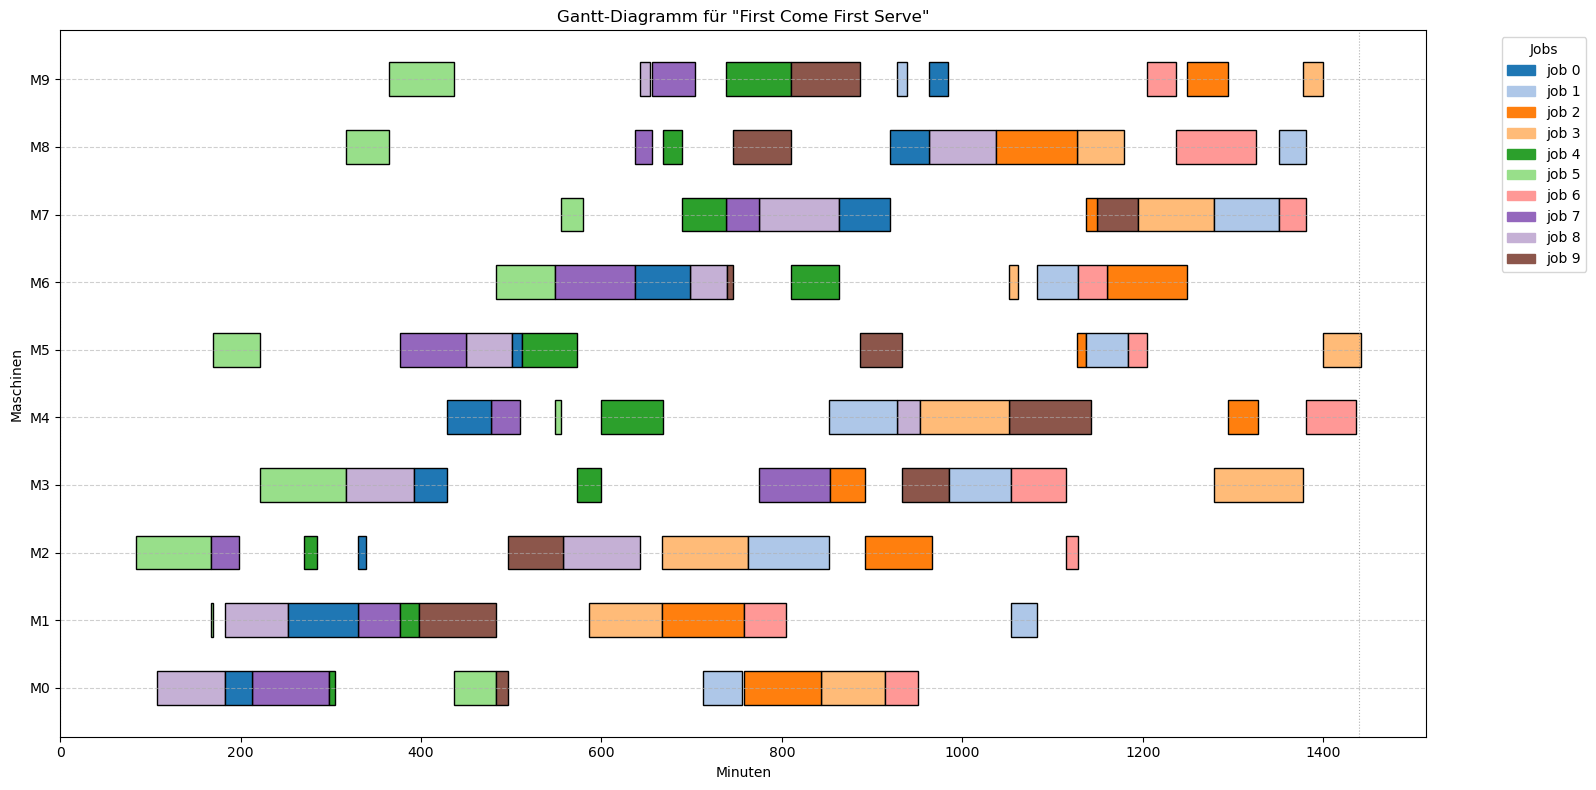

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [28]:
category = "First Come First Serve"

show.plot_gantt_jobs(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_fcfs, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_fcfs, instance)

### b) HiGHS

In [30]:
df_schedule_highs, makespan = ssv.solve_jssp_global_makespan(instance, df_arrivals, solver_time_limit=360)
df_schedule_highs.sort_values(by="Start").reset_index(drop=True)
df_schedule_highs

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,job 6,747.96,M1,758.25,46,56.29,804.25
1,job 6,747.96,M0,914.31,37,203.35,951.31
2,job 6,747.96,M3,1013.25,61,326.29,1074.25
3,job 6,747.96,M2,1074.37,13,339.41,1087.37
4,job 6,747.96,M6,1087.37,32,371.41,1119.37
...,...,...,...,...,...,...,...
95,job 5,83.59,M9,364.59,72,353.00,436.59
96,job 5,83.59,M0,439.80,47,403.21,486.80
97,job 5,83.59,M6,486.80,65,468.21,551.80
98,job 5,83.59,M4,551.80,6,474.21,557.80


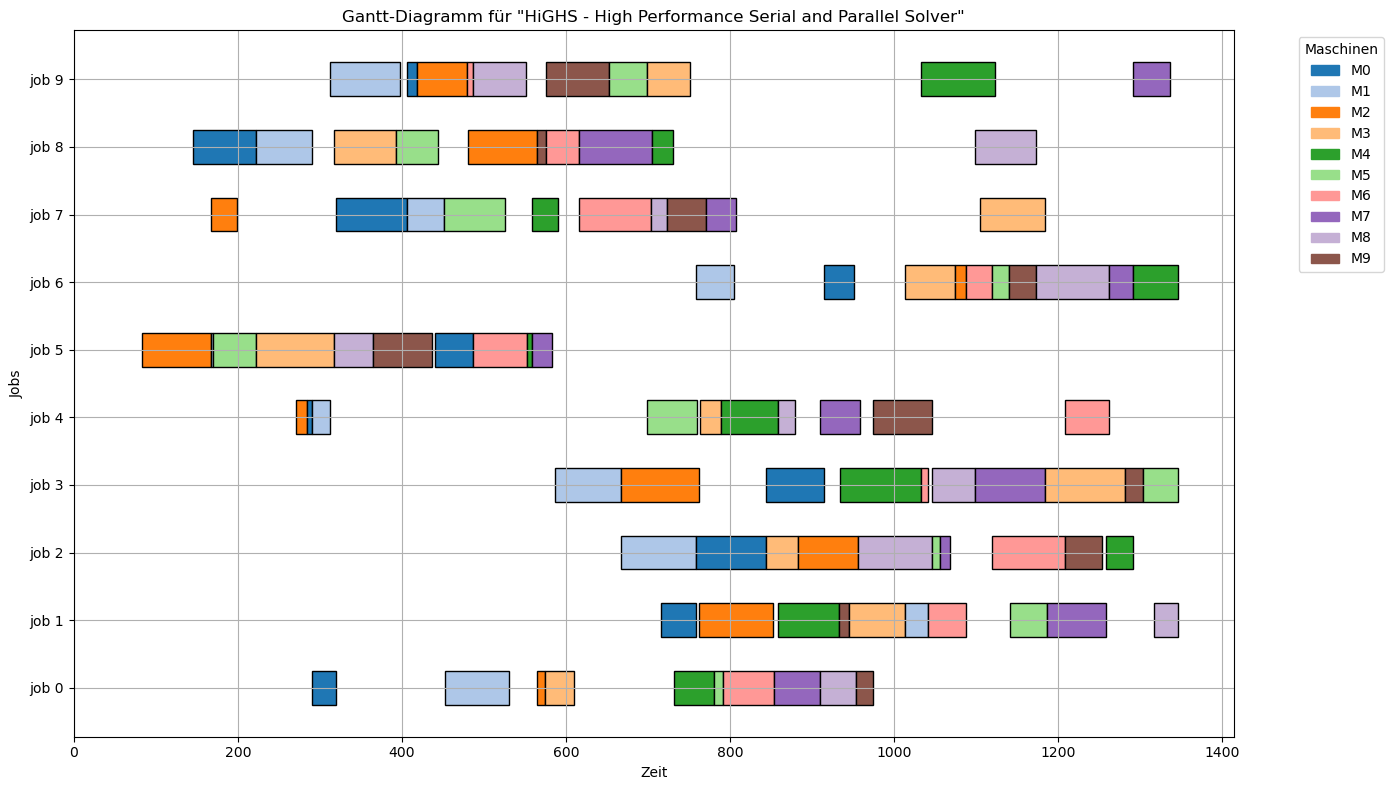

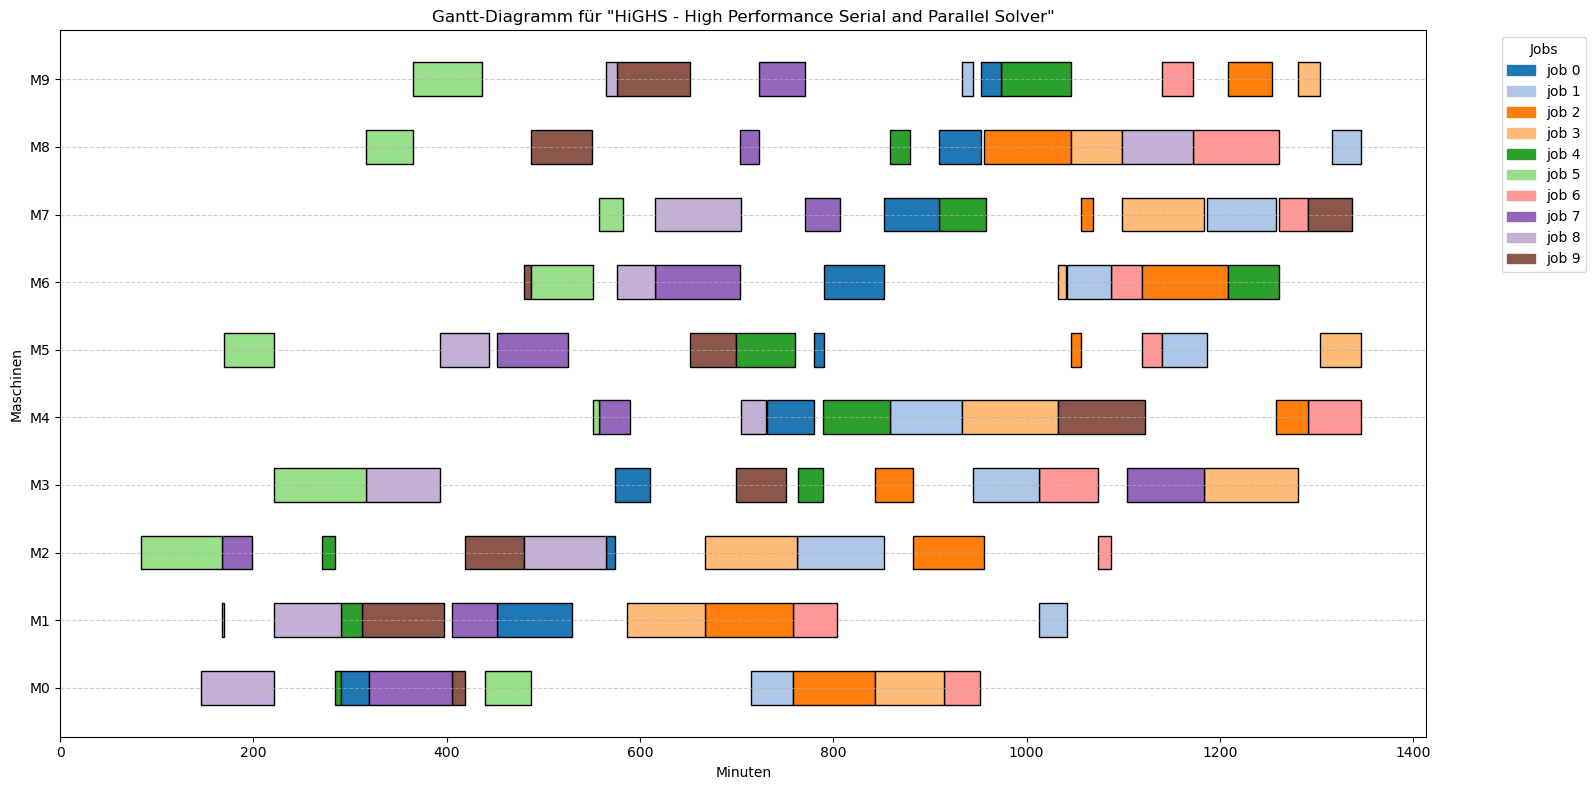

✅ Keine Maschinenkonflikte gefunden
✅ Job-Machinen-Reihenfolge (Reihenfolge der Operationen je Job) ist korrekt!
✅ Alle Operation starten erst nach Arrival des Job
✅ Zeitliche technologische Reihenfolge korrekt.

✅ Alle Constraints wurden erfüllt.



True

In [31]:
category = "HiGHS - High Performance Serial and Parallel Solver"

show.plot_gantt_jobs(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))
show.plot_gantt_machines(df_schedule_highs, 'Gantt-Diagramm für "{}"'.format(category))

check.check_all_constraints(df_schedule_highs, instance)

### Export

In [33]:
df_schedule_highs.to_csv("data/02_schedule.csv", index = False)